## tf.data
- dataframe은 customized 하기가 어렵다.

장점
- customized가 좋다
- 국한되지 않음

단점
- 구현이 어렵다.

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_paths = glob('../dataset/cifar/train/*.png')
path = data_paths[0]
path

'../dataset/cifar/train\\0_frog.png'

- Image Decode Method

In [3]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)

In [4]:
image.shape

TensorShape([32, 32, 3])

- RGB이므로 차원 축소하지 않아도 됨.

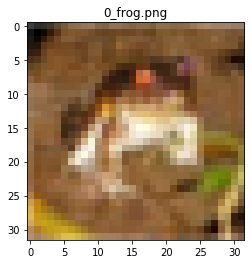

In [5]:
plt.title(os.path.basename(path))
plt.imshow(image)
plt.show()

## tf.data

In [6]:
data_paths[:10]

['../dataset/cifar/train\\0_frog.png',
 '../dataset/cifar/train\\10000_automobile.png',
 '../dataset/cifar/train\\10001_frog.png',
 '../dataset/cifar/train\\10002_frog.png',
 '../dataset/cifar/train\\10003_ship.png',
 '../dataset/cifar/train\\10004_ship.png',
 '../dataset/cifar/train\\10005_cat.png',
 '../dataset/cifar/train\\10006_deer.png',
 '../dataset/cifar/train\\10007_frog.png',
 '../dataset/cifar/train\\10008_airplane.png']

- 이미지 읽어오는 함수 선언

In [7]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image

- Tensorflow Dataset의 map 함수를 이용하여 map_func를 인자로 받아 이미지를 Load함.

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)

In [9]:
# batch를 적용하지 않은 상태로 3 dimension이다.
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

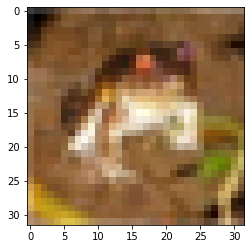

In [10]:
plt.imshow(tf_image)
plt.show()

## Batch 로 묶기

In [11]:
batch_size = 8

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)

In [13]:
# batch size를 적용한 상태로 4 dimension임
tf_image = next(iter(dataset))
tf_image.shape # [batch, width, height, channel]

TensorShape([8, 32, 32, 3])

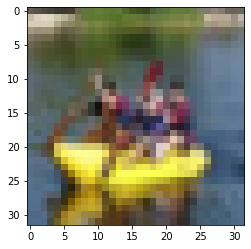

In [14]:
plt.imshow(tf_image[4])
plt.show()

## Shuffle하기
- 공식 homepae에서는 파일 사이즈만큼(Train 갯수) 준다
- buffer size 높으면 로드가 느려지지만 처리 속도는 빨라진다.

In [15]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths) # 데이터 경로
dataset = dataset.map(read_image) # 이미지 로드하는 함수
dataset = dataset.batch(batch_size) 
dataset = dataset.shuffle(buffer_size=len(data_paths)) 

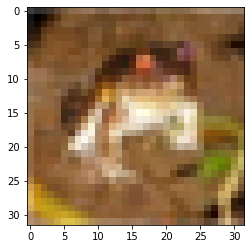

In [16]:
tf_images = next(iter(dataset))

plt.imshow(tf_images[0])
plt.show()

## Image와 Label을 같이 넣기 함께 Generate

In [17]:
path

'../dataset/cifar/train\\0_frog.png'

- Label 얻기

In [18]:
def get_label(path):
    return path.split('_')[-1].replace('.png', '')

In [19]:
path, get_label(path)

('../dataset/cifar/train\\0_frog.png', 'frog')

In [20]:
label_names = [get_label(path) for path in data_paths]

In [21]:
label_names[:10]

['frog',
 'automobile',
 'frog',
 'frog',
 'ship',
 'ship',
 'cat',
 'deer',
 'frog',
 'airplane']

In [22]:
cls_names = np.unique(label_names)
cls_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

- onehot encoding 으로 표현

In [23]:
cls_names == 'frog'

array([False, False, False, False, False, False,  True, False, False,
       False])

In [24]:
onehot_encoding = np.array(cls_names == 'frog', np.uint8)
onehot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [25]:
#from tensorflow.keras.utils import to_categorical

#label_onehot = to_categorical(label, num_classes=10)
#label_onehot

In [26]:
def onehot_encoding(label):
    return np.array(class_names == label, np.uint8)

In [27]:
def read_image_label(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image, label

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((data_paths, label_names)) # 튜플로 들어감
dataset = dataset.map(read_image_label)
# shuffle은 시간이 오래걸리므로 패스
dataset = dataset.batch(batch_size)
dataset = dataset.repeat() # repeat하지 않으면 1번 epoch하고 끝나버린다.

In [29]:
image, label = next(iter(dataset))
image.shape, label.shape

(TensorShape([8, 32, 32, 3]), TensorShape([8]))

In [30]:
label[0]

<tf.Tensor: id=431, shape=(), dtype=string, numpy=b'frog'>

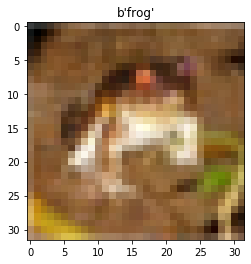

In [31]:
plt.imshow(image[0])
plt.title(np.array(label[0]))
plt.show()

## tensorflow 함수로 label 얻기

In [32]:
path

'../dataset/cifar/train\\0_frog.png'

In [33]:
def onehot_encoding(label):
    return np.array(class_names == label, np.uint8)

In [34]:
fname = tf.strings.split(path, '_')[-1]
cls_name = tf.strings.regex_replace(fname, '.png', '')
cls_name, fname

(<tf.Tensor: id=503, shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: id=502, shape=(), dtype=string, numpy=b'frog.png'>)

In [35]:
cls_names == cls_name

<tf.Tensor: id=505, shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False, False,  True, False, False,
       False])>

In [36]:
# boolean을 uint8로 변경하여 onehot encoding으로 변경
onehot_encoding = tf.cast(cls_names == cls_name, tf.uint8)
onehot_encoding

<tf.Tensor: id=508, shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

In [37]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    cls_name = tf.strings.regex_replace(fname, '.png', '')
    onehot_encoding = tf.cast(cls_names == cls_name, tf.uint8)
    return onehot_encoding

In [42]:
def read_image_label(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # get label
    label = get_label(path)
    
    return image, label

In [43]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image_label)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

In [44]:
image, label = next(iter(dataset))
image.shape,label.shape

(TensorShape([8, 32, 32, 3]), TensorShape([8, 10]))

C:\Users\ynebu\Anaconda3\envs\tensoflow2.0\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


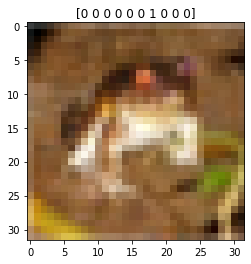

In [45]:
plt.imshow(image[0])
plt.title(np.array(label[0]))
plt.show()

In [ ]:
l